In [3]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Cài đặt để đồ thị hiển thị đẹp hơn
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (15, 7)

In [4]:
# Tải dữ liệu
df = pd.read_csv('london_weather.csv')

# --- 1.1: Xử lý cột `date` ---
# Chuyển cột date sang định dạng datetime, đây là bước nền tảng
df['date'] = pd.to_datetime(df['date'], format='%Y%m%d')

# Sắp xếp lại dataframe theo ngày tháng để đảm bảo tính tuần tự
df = df.sort_values(by='date').reset_index(drop=True)

# --- 1.2: Xử lý giá trị bị thiếu ---
# Chúng ta sẽ sử dụng phương pháp nội suy theo thời gian (time interpolation)
# để điền giá trị thiếu. Đây là cách tiếp cận tốt hơn là điền bằng trung vị
# cho dữ liệu chuỗi thời gian.
print("Xử lý giá trị bị thiếu bằng phương pháp nội suy...")
df.interpolate(method='time', inplace=True)

# Kiểm tra lại, nếu vẫn còn giá trị thiếu ở đầu (do không có điểm trước đó để nội suy)
# thì sẽ điền bằng phương pháp điền ngược (backfill)
if df.isnull().sum().sum() > 0:
    df.fillna(method='bfill', inplace=True)

print("Đã xử lý xong các giá trị thiếu.")

# --- 1.3: Kỹ thuật Đặc trưng (Feature Engineering) ---
# Đây là bước quan trọng nhất để cung cấp "bối cảnh" cho mô hình
print("Bắt đầu tạo các đặc trưng mới...")

# 1.3.1. Đặc trưng thời gian cơ bản
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['day_of_week'] = df['date'].dt.dayofweek  # Thứ hai=0, Chủ nhật=6
df['day_of_year'] = df['date'].dt.dayofyear
df['week_of_year'] = df['date'].dt.isocalendar().week.astype(int)

# 1.3.2. Đặc trưng trễ (Lag Features)
# Tạo các đặc trưng chứa giá trị của các ngày trước đó
# Điều này giúp mô hình "nhớ" được những gì đã xảy ra gần đây
lags = [1, 2, 3, 7, 14, 30] # Lấy dữ liệu từ 1, 2, 3, 7, 14, 30 ngày trước
target_col = 'mean_temp'

for lag in lags:
    df[f'{target_col}_lag_{lag}'] = df[target_col].shift(lag)

print("Đã tạo xong các đặc trưng trễ (Lag features).")

# 1.3.3. Đặc trưng cửa sổ trượt (Rolling Window Features)
# Tạo các đặc trưng thống kê trên một cửa sổ thời gian
# Ví dụ: nhiệt độ trung bình của 7 ngày qua
window_sizes = [7, 14, 30]

for window in window_sizes:
    # Shift(1) để đảm bảo không sử dụng thông tin của ngày hiện tại
    rolling_window = df[target_col].shift(1).rolling(window=window)
    df[f'{target_col}_rolling_mean_{window}'] = rolling_window.mean()
    df[f'{target_col}_rolling_std_{window}'] = rolling_window.std()
    df[f'{target_col}_rolling_min_{window}'] = rolling_window.min()
    df[f'{target_col}_rolling_max_{window}'] = rolling_window.max()

print("Đã tạo xong các đặc trưng cửa sổ trượt (Rolling Window features).")

# Loại bỏ các dòng có giá trị NaN do quá trình shift và rolling
# Các dòng này nằm ở đầu của DataFrame
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

print(f"\nKích thước dữ liệu sau khi tiền xử lý: {df.shape}")
print("Các cột mới được tạo ra:")
print(df.columns)

Xử lý giá trị bị thiếu bằng phương pháp nội suy...


NotImplementedError: 

In [ ]:
# Lại một lần nữa loại bỏ các cột không nên dùng
# Giữ lại các đặc trưng mới tạo
features_to_drop = ['date', 'mean_temp', 'max_temp', 'min_temp']
features = [col for col in df.columns if col not in features_to_drop]

X = df[features]
y = df['mean_temp']

# Chia dữ liệu theo thời gian. Giữ lại 3 năm cuối (2018-2020) để kiểm tra
train_end_date = '2017-12-31'

X_train = X[df['date'] <= train_end_date]
y_train = y[df['date'] <= train_end_date]

X_test = X[df['date'] > train_end_date]
y_test = y[df['date'] > train_end_date]

# Bỏ cột `date` khỏi tập X sau khi đã chia xong
X_train = X_train.drop('date', axis=1)
X_test = X_test.drop('date', axis=1)

print(f"\nKích thước tập huấn luyện: {X_train.shape}")
print(f"Kích thước tập kiểm tra: {X_test.shape}")

In [ ]:
# Khởi tạo mô hình LightGBM Regressor
# Sử dụng một vài tham số cơ bản để bắt đầu
lgbm = lgb.LGBMRegressor(
    objective='mae',       # Tối ưu hóa theo Mean Absolute Error
    metric='mae',
    n_estimators=1000,     # Số lượng cây (cây quyết định) sẽ xây dựng
    learning_rate=0.05,
    num_leaves=31,
    n_jobs=-1,             # Sử dụng tất cả các nhân CPU có sẵn
    seed=42
)

# Huấn luyện mô hình
# Sử dụng early_stopping_rounds để dừng huấn luyện sớm nếu hiệu suất trên tập validation không cải thiện
# Chúng ta sẽ dùng 10% cuối của tập train làm tập validation tạm thời
print("\nBắt đầu huấn luyện mô hình LightGBM...")

eval_set = [(X_train.iloc[-int(len(X_train)*0.1):], y_train.iloc[-int(len(y_train)*0.1):])]

lgbm.fit(
    X_train, y_train,
    eval_set=eval_set,
    eval_metric='mae',
    callbacks=[lgb.early_stopping(100, verbose=True)] # Dừng nếu sau 100 vòng không cải thiện
)
print("\nHuấn luyện hoàn tất.")

In [ ]:
# Dự đoán trên tập test
y_pred_lgbm = lgbm.predict(X_test)

# Đánh giá hiệu suất
mae_lgbm = mean_absolute_error(y_test, y_pred_lgbm)
mse_lgbm = mean_squared_error(y_test, y_pred_lgbm)
r2_lgbm = r2_score(y_test, y_pred_lgbm)

print(f"\n--- Kết quả cuối cùng với LightGBM ---")
print(f"Mean Absolute Error (MAE): {mae_lgbm:.2f}°C")
print(f"Mean Squared Error (MSE): {mse_lgbm:.2f}")
print(f"R-squared (R²): {r2_lgbm:.2f}")

In [ ]:
# Trực quan hóa mức độ quan trọng của các đặc trưng
lgb.plot_importance(lgbm, figsize=(12, 10), max_num_features=20, importance_type='gain')
plt.title('Mức độ quan trọng của các Đặc trưng (Feature Importance)')
plt.show()

In [ ]:
# Tạo DataFrame để so sánh và lấy lại index ngày tháng
results_df_lgbm = pd.DataFrame({
    'date': df['date'][y_test.index], # Lấy ngày tháng tương ứng với tập test
    'Thực tế': y_test,
    'Dự đoán': y_pred_lgbm
}).set_index('date')

# Vẽ đồ thị cho một khoảng thời gian trong tập test để xem rõ hơn
plt.figure(figsize=(20, 8))
results_df_lgbm['2018-06-01':'2018-08-31'].plot(kind='line', marker='.', linestyle='-')
plt.title('So sánh Thực tế và Dự đoán (Mùa hè 2018)')
plt.ylabel('Nhiệt độ trung bình (°C)')
plt.legend()
plt.grid(True)
plt.show()

Xử lý giá trị bị thiếu bằng phương pháp nội suy...
Đã xử lý xong các giá trị thiếu.
Bắt đầu tạo các đặc trưng mới...
Đã tạo xong các đặc trưng trễ (Lag features).
Đã tạo xong các đặc trưng cửa sổ trượt (Rolling Window features).

Kích thước dữ liệu sau khi tiền xử lý: (15311, 34)

Bắt đầu huấn luyện mô hình LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001919 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5632
[LightGBM] [Info] Number of data points in the train set: 12793, number of used features: 30
[LightGBM] [Info] Start training from score 11.200000
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[139]	valid_0's l1: 1.3841

Huấn luyện hoàn tất.

--- Kết quả cuối cùng với LightGBM ---
Mean Absolute Error (MAE): 1.55°C
Mean Squared Error (MSE): 3.87
R-squared (R²): 0.89


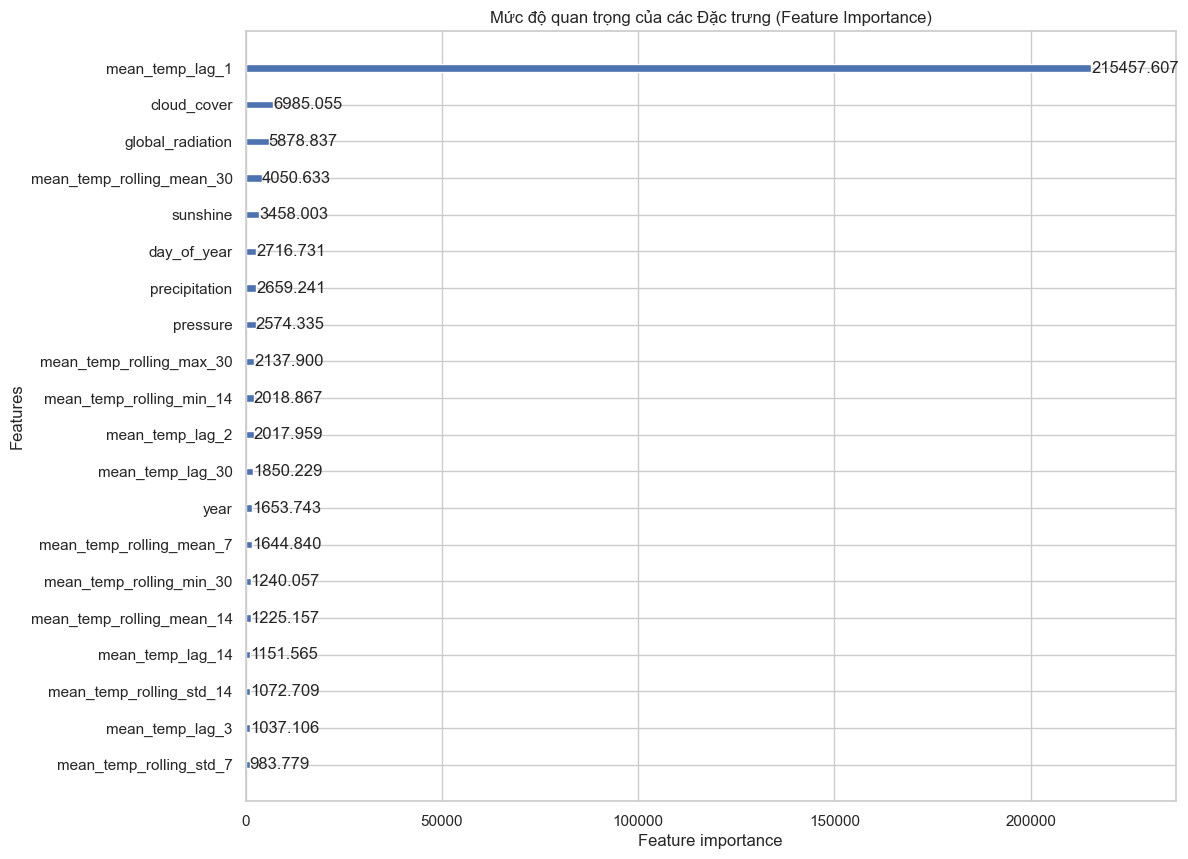

<Figure size 2000x800 with 0 Axes>

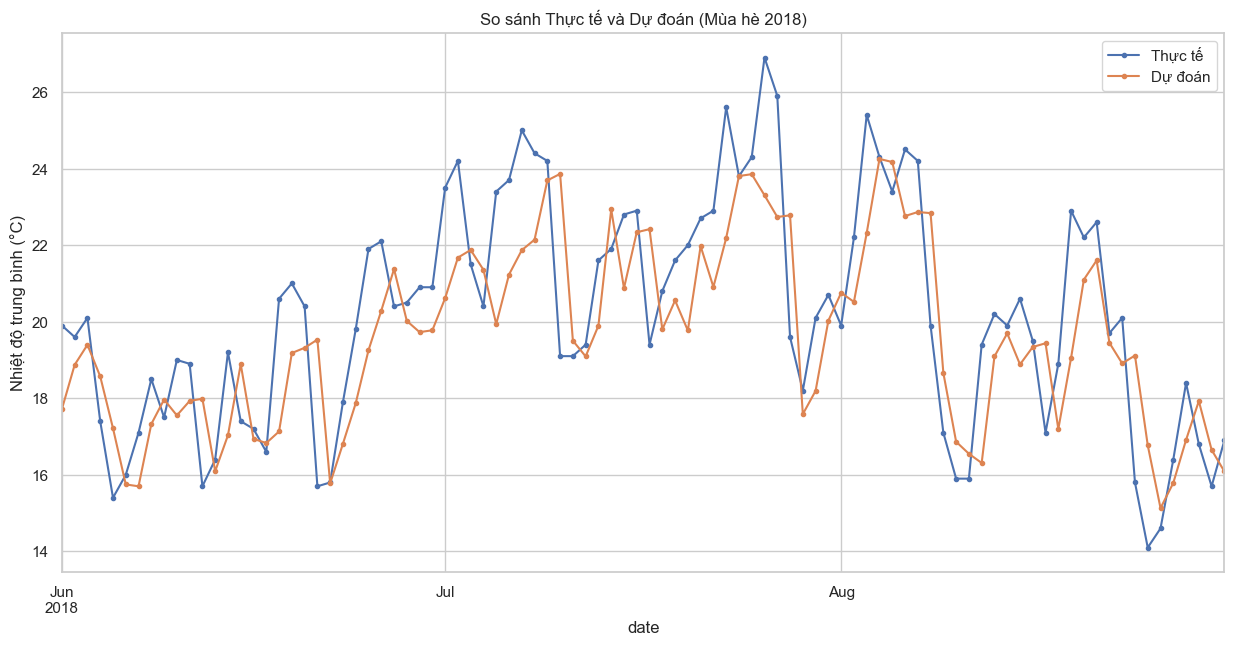

In [5]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Cài đặt để đồ thị hiển thị đẹp hơn
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (15, 7)

# Tải dữ liệu
df = pd.read_csv('london_weather.csv')

# --- 1.1: Xử lý cột `date` ---
df['date'] = pd.to_datetime(df['date'], format='%Y%m%d')

# ### <<< SỬA ĐỔI 1: Đặt cột 'date' làm index cho DataFrame >>> ###
# Đây là bước quan trọng để phương thức nội suy 'time' hoạt động
df.set_index('date', inplace=True)

# Sắp xếp lại dataframe theo index (theo ngày tháng)
df.sort_index(inplace=True)


# --- 1.2: Xử lý giá trị bị thiếu ---
print("Xử lý giá trị bị thiếu bằng phương pháp nội suy...")
# Bây giờ lệnh này sẽ hoạt động vì index đã là datetime
df.interpolate(method='time', inplace=True)

# Kiểm tra lại, nếu vẫn còn giá trị thiếu ở đầu
if df.isnull().sum().sum() > 0:
    df.fillna(method='bfill', inplace=True)

print("Đã xử lý xong các giá trị thiếu.")

# ### <<< SỬA ĐỔI 2: Reset index để 'date' trở lại thành cột >>> ###
# Chúng ta cần 'date' là một cột để có thể tạo các đặc trưng năm, tháng, ngày
df.reset_index(inplace=True)


# --- 1.3: Kỹ thuật Đặc trưng (Feature Engineering) ---
print("Bắt đầu tạo các đặc trưng mới...")

# 1.3.1. Đặc trưng thời gian cơ bản
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['day_of_week'] = df['date'].dt.dayofweek
df['day_of_year'] = df['date'].dt.dayofyear
df['week_of_year'] = df['date'].dt.isocalendar().week.astype(int)

# 1.3.2. Đặc trưng trễ (Lag Features)
lags = [1, 2, 3, 7, 14, 30]
target_col = 'mean_temp'
for lag in lags:
    df[f'{target_col}_lag_{lag}'] = df[target_col].shift(lag)

print("Đã tạo xong các đặc trưng trễ (Lag features).")


# 1.3.3. Đặc trưng cửa sổ trượt (Rolling Window Features)
window_sizes = [7, 14, 30]
for window in window_sizes:
    rolling_window = df[target_col].shift(1).rolling(window=window)
    df[f'{target_col}_rolling_mean_{window}'] = rolling_window.mean()
    df[f'{target_col}_rolling_std_{window}'] = rolling_window.std()
    df[f'{target_col}_rolling_min_{window}'] = rolling_window.min()
    df[f'{target_col}_rolling_max_{window}'] = rolling_window.max()

print("Đã tạo xong các đặc trưng cửa sổ trượt (Rolling Window features).")


# Loại bỏ các dòng có giá trị NaN do quá trình shift và rolling
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

print(f"\nKích thước dữ liệu sau khi tiền xử lý: {df.shape}")

# --- Các bước tiếp theo (Phân chia, Huấn luyện, Đánh giá) không thay đổi ---

# Lựa chọn đặc trưng
features_to_drop = ['date', 'mean_temp', 'max_temp', 'min_temp']
features = [col for col in df.columns if col not in features_to_drop]
X = df[features]
y = df['mean_temp']

# Phân chia dữ liệu
train_end_date = '2017-12-31'
X_train = X[df['date'] <= train_end_date]
y_train = y[df['date'] <= train_end_date]
X_test = X[df['date'] > train_end_date]
y_test = y[df['date'] > train_end_date]

# Bỏ cột 'date' khỏi tập X sau khi đã chia xong
X_train = X_train.drop('date', axis=1, errors='ignore')
X_test = X_test.drop('date', axis=1, errors='ignore')


# Huấn luyện mô hình
print("\nBắt đầu huấn luyện mô hình LightGBM...")
lgbm = lgb.LGBMRegressor(
    objective='mae',
    metric='mae',
    n_estimators=1000,
    learning_rate=0.05,
    num_leaves=31,
    n_jobs=-1,
    seed=42
)

# Tạo tập validation từ 10% cuối của tập train
train_val_split_index = int(len(X_train) * 0.9)
X_train_part = X_train[:train_val_split_index]
y_train_part = y_train[:train_val_split_index]
X_val_part = X_train[train_val_split_index:]
y_val_part = y_train[train_val_split_index:]

eval_set = [(X_val_part, y_val_part)]

lgbm.fit(
    X_train_part, y_train_part,
    eval_set=eval_set,
    eval_metric='mae',
    callbacks=[lgb.early_stopping(100, verbose=True)]
)

print("\nHuấn luyện hoàn tất.")

# Đánh giá mô hình
y_pred_lgbm = lgbm.predict(X_test)
mae_lgbm = mean_absolute_error(y_test, y_pred_lgbm)
mse_lgbm = mean_squared_error(y_test, y_pred_lgbm)
r2_lgbm = r2_score(y_test, y_pred_lgbm)

print(f"\n--- Kết quả cuối cùng với LightGBM ---")
print(f"Mean Absolute Error (MAE): {mae_lgbm:.2f}°C")
print(f"Mean Squared Error (MSE): {mse_lgbm:.2f}")
print(f"R-squared (R²): {r2_lgbm:.2f}")

# Trực quan hóa mức độ quan trọng
lgb.plot_importance(lgbm, figsize=(12, 10), max_num_features=20, importance_type='gain')
plt.title('Mức độ quan trọng của các Đặc trưng (Feature Importance)')
plt.show()

# Trực quan hóa dự đoán
results_df_lgbm = pd.DataFrame({
    'date': df['date'][y_test.index],
    'Thực tế': y_test.values,
    'Dự đoán': y_pred_lgbm
}).set_index('date')

plt.figure(figsize=(20, 8))
results_df_lgbm['2018-06-01':'2018-08-31'].plot(kind='line', marker='.', linestyle='-')
plt.title('So sánh Thực tế và Dự đoán (Mùa hè 2018)')
plt.ylabel('Nhiệt độ trung bình (°C)')
plt.legend()
plt.grid(True)
plt.show()